In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import fit_quenching_linear, calc_quenched_flour, mark_non_quenchers
from quenching import well_mean_with_error_propagation

These notebooks 
1. load the relevant data (RTDP/O2NS with pure quenchers/supernatants).
2. blanks the data against the measurements of buffer before sensor addition (RTDP/O2NS) propagating error in the blank.
3. calculate the fluorescence expected in the case of no interaction (some of the individual molecules overlap with sensor fluorescence).
4. take the means of the remaining measurements on a per-well basis for further calculation.
4. calculate $F_0/F$ - the ratio of sensor intensity alone in buffer to intensity with a defined quencher conc. 
8. Fit this against the linearized Stern-Volmer eqn to get a quenching coefficient $K_{SV}$ for each molecule. 
9. Determine from the fits which molecules should be considered "quenchers." 
10. Save all the above data, inspects results in plots for sanity checking. 

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/RTDP_vitro/RTDP_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/RTDP_vitro/RTDP_long_df_post.csv', index_col=0)

# Drop first timepoint so that the measurement has stabilized.
long_df_pre = long_df_pre[long_df_pre.time_s > 0]
long_df_post = long_df_post[long_df_post.time_s > 0]

# Older experiments, used a different dilution factor
post_rtdp_dilution_factor = 1.0-1.0/101

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, rtdp_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "rtdp_fluor", "RTDP",
    dilution_factor=post_rtdp_dilution_factor)

long_df_pre.to_csv("../data/RTDP_vitro/RTDP_long_df_pre_processed.csv")
long_df_post.to_csv("../data/RTDP_vitro/RTDP_long_df_post_processed.csv")

print("blanks\n", blank_vals)
print("RTDP in buffer\n", rtdp_alone_fluors)
stds = np.array([v.std_dev for v in rtdp_alone_fluors])
vals = np.array([v.nominal_value for v in rtdp_alone_fluors])
cvs = stds/vals
print("CV of RTDP in buffer (%)\n", 100*cvs) 


blanks
 date
1/10/22       0.4+/-0.6
11/23/21    0.99+/-0.17
12/7/21         1.0+/-0
dtype: object
RTDP in buffer
 date
1/10/22     (4.00+/-0.22)e+03
11/23/21    (4.45+/-0.22)e+03
12/7/21     (3.90+/-0.12)e+03
dtype: object
CV of RTDP in buffer (%)
 [5.52560114 5.04030589 3.10323476]


In [3]:
# Peek at the data
long_df_post.head()
long_df_pre.name.unique()

array(['PYO', 'PMS', 'AQDS', 'BLANK', 'PCA', 'TOXO', 'DMSO', 'GLUCOSE',
       'ACETATE', 'GLUTAMATE', '4-AMINO-SAL', 'CHLORAM', 'KANAMY', 'NAD+',
       'FAD', 'RIBOFLAV', 'TETRACY'], dtype=object)

In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "rtdp_fluor", rtdp_alone_fluors)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "rtdp_fluor", rtdp_alone_fluors)
means_pre_by_rep.to_csv("../data/RTDP_vitro/mean_rtdp_fluor_pre.csv")
means_post_by_rep.to_csv("../data/RTDP_vitro/mean_rtdp_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. 
# See Gehlen J. Photochem. Photobio. 2020 for summary and Szabo J Phys Chem 1989 for derivations. 

# We see signs of inner filter effects from the fluorescence of pure molecules
# prior to RTDP addition, so fit only the lower concentrations for those that are 
# problematic. Many of the negative controls are roughly non-fluorescent so we 
# can fit the whole curve for those.
name_order = sorted(
    set(long_df_post.name.unique()).difference('BLANK,RTDP'.split(',')))
print(name_order)
fitting_df = means_post_by_rep.reset_index()
# these ones are essentially non-fluorescent, no need to trim their data
names2skip = 'DMSO,GLUCOSE,ACETATE,GLUTAMATE,4-AMINO-SAL,KANAMY'.split(',')
mask = np.logical_or(
    fitting_df.name.isin(names2skip),
    fitting_df.concentration < 300)
fitting_df = fitting_df[mask]

quencher_fit_df = fit_quenching_linear(fitting_df, name_order)

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enought to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (O2NS here) in buffer. 
max_cv = np.max(cvs)
min_KSV = max_cv*4.45e3

print("Minimum K_SV: {0:.2g}".format(min_KSV))
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_KSV=min_KSV)

# Save the fits
quencher_fit_df.to_csv("../data/RTDP_vitro/fits.csv")
quencher_fit_df

['4-AMINO-SAL', 'ACETATE', 'AQDS', 'CHLORAM', 'DMSO', 'FAD', 'GLUCOSE', 'GLUTAMATE', 'KANAMY', 'NAD+', 'PCA', 'PMS', 'PYO', 'RIBOFLAV', 'TETRACY', 'TOXO']
Fitting 4-AMINO-SAL
	F0/F ~ [4-AMINO-SAL] with R = -0.068
	Data for 8 concentrations
Fitting ACETATE
	F0/F ~ [ACETATE] with R = -0.250
	Data for 8 concentrations
Fitting AQDS
	F0/F ~ [AQDS] with R = 0.972
	Data for 7 concentrations
Fitting CHLORAM
	F0/F ~ [CHLORAM] with R = 0.651
	Data for 7 concentrations
Fitting DMSO
	F0/F ~ [DMSO] with R = -0.465
	Data for 8 concentrations
Fitting FAD
	F0/F ~ [FAD] with R = 0.979
	Data for 7 concentrations
Fitting GLUCOSE
	F0/F ~ [GLUCOSE] with R = -0.498
	Data for 8 concentrations
Fitting GLUTAMATE
	F0/F ~ [GLUTAMATE] with R = -0.371
	Data for 8 concentrations
Fitting KANAMY
	F0/F ~ [KANAMY] with R = -0.363
	Data for 8 concentrations
Fitting NAD+
	F0/F ~ [NAD+] with R = 0.168
	Data for 7 concentrations
Fitting PCA
	F0/F ~ [PCA] with R = 0.934
	Data for 7 concentrations
Fitting PMS
	F0/F ~ [PMS] w

,name,K_SV,K_SV err,R,N_concs,K_SV (/M),K_SV err (/M),quencher
0,4-AMINO-SAL,4.737391e-06,6.106702e-05,-0.067862,8,4.737391,61.067025,False
1,ACETATE,-1.763661e-06,3.004881e-06,-0.250244,8,-1.763661,3.004881,False
2,AQDS,3.983712e-03,3.563433e-04,0.971947,7,3983.711740,356.343348,True
3,CHLORAM,9.783819e-04,1.488850e-04,0.650575,7,978.381909,148.884985,True
4,DMSO,-1.729597e-07,5.179461e-08,-0.464937,8,-0.172960,0.051795,False
5,FAD,7.609573e-03,5.555301e-04,0.979313,7,7609.572856,555.530085,True
6,GLUCOSE,-5.622375e-06,2.908200e-06,-0.498368,8,-5.622375,2.908200,False
7,GLUTAMATE,-2.439294e-05,6.825022e-05,-0.371213,8,-24.392937,68.250216,False
8,KANAMY,-1.275456e-04,5.820224e-05,-0.362522,8,-127.545587,58.202245,False
9,NAD+,1.141407e-04,2.252524e-04,0.168451,7,114.140696,225.252438,False


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

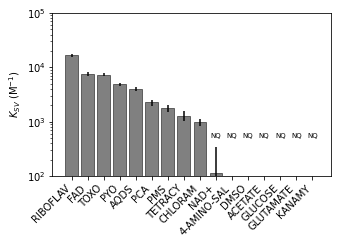

In [6]:
# Take a peek at the linear KSV fits. 
# Index fits by name for easier lookup
rtdp_fits = quencher_fit_df.set_index('name').sort_values('K_SV (/M)', ascending=False)

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, so it gives much larger errors in the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(rtdp_fits.index.size)
ys = rtdp_fits['K_SV (/M)']
yerr = rtdp_fits['K_SV err (/M)']

plt.figure(figsize=(5,3))
plt.yscale('log')
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(rtdp_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 5e2, 'NQ', ha='center', fontsize=7)

plt.ylim(1e2, 1e5)
plt.ylabel('$K_{SV}$ (M$^{-1}$)')
plt.xticks(xs, rtdp_fits.index, rotation=45, ha='right')
plt.show()

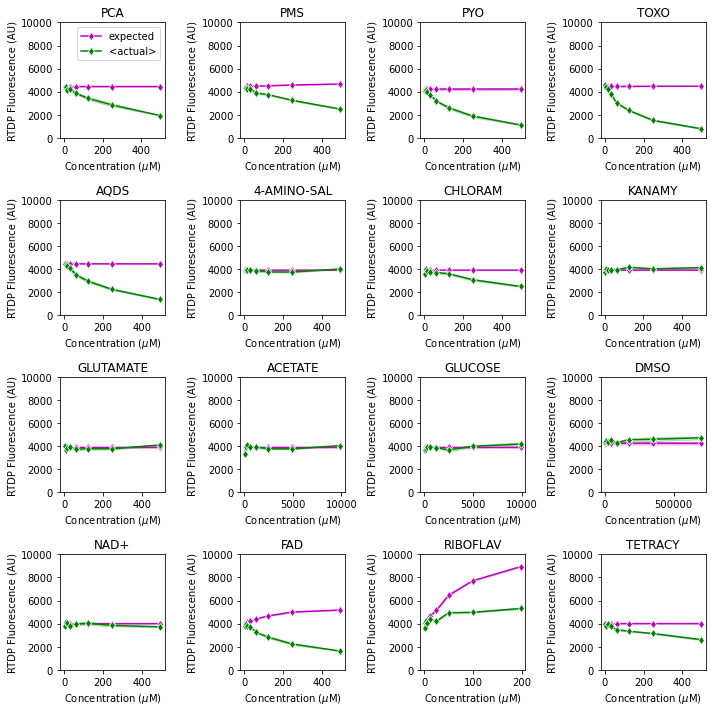

In [7]:
fig, axs = plt.subplots(figsize=(10,10), ncols=4, nrows=4)
flat_axs = axs.flatten()
name_order = ['PCA', 'PMS', 'PYO', 'TOXO', 'AQDS', '4-AMINO-SAL', 'CHLORAM', 
              'KANAMY', 'GLUTAMATE', 'ACETATE', 'GLUCOSE', 'DMSO',
              'NAD+', 'FAD', 'RIBOFLAV', 'TETRACY']

for i, (qname, my_ax) in enumerate(zip(name_order, flat_axs)):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
        
    sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_rtdp_fluor', 
                 color='m', marker='d', markersize=6, label='expected')
    
    sns.lineplot(data=qdf_post, x='concentration', y='blanked_rtdp_fluor', 
                 color='g', marker='d', markersize=6, 
                 label='<actual>')
    
    plt.title(qname)
    plt.ylim(0, 10000)
    plt.xlabel('Concentration ($\mu$M)')
    plt.ylabel('RTDP Fluorescence (AU)')
    
    if i > 0:
        plt.legend().set_visible(False)
    
plt.tight_layout()
plt.savefig('../figures/rtdp_per_q_traces.png', facecolor='w', dpi=600)
plt.show()

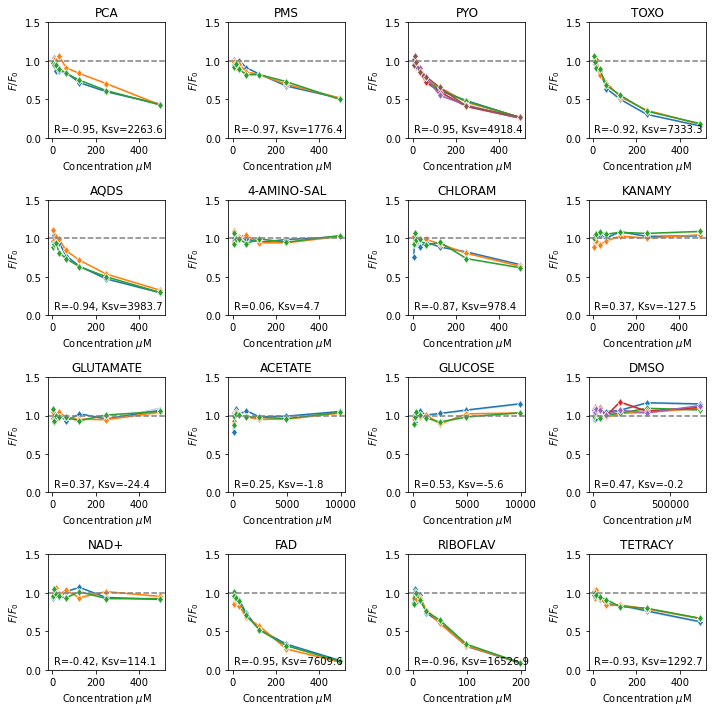

In [8]:
fig, axs = plt.subplots(figsize=(10,10), ncols=4, nrows=4)
flat_axs = axs.flatten()
name_order = ['PCA', 'PMS', 'PYO', 'TOXO', 'AQDS', '4-AMINO-SAL', 'CHLORAM', 
              'KANAMY', 'GLUTAMATE', 'ACETATE', 'GLUCOSE', 'DMSO',
              'NAD+', 'FAD', 'RIBOFLAV', 'TETRACY']

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    sns.lineplot(data=qdf_post, x='concentration', y='F_F0_ratio', 
                 color='m', marker='d', markersize=6,
                 hue=qdf_post[['date', 'replicate']].apply(tuple, axis=1),
                 legend=False)
    
    corr = qdf_post.corr().loc['concentration', 'F_F0_ratio']
    slope = rtdp_fits.loc[qname]['K_SV (/M)']
    plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.1f}'.format(corr, slope),
             transform=my_ax.transAxes)
    plt.axhline(1, ls='--', color='grey')
    
    plt.title(qname)
    plt.ylim(0, 1.5)
    plt.xlabel('Concentration $\mu$M')
    plt.ylabel('$F / F_0$')
    
plt.tight_layout()
plt.savefig('../figures/rtdp_per_q_corr.png', facecolor='w', dpi=600)
plt.show()

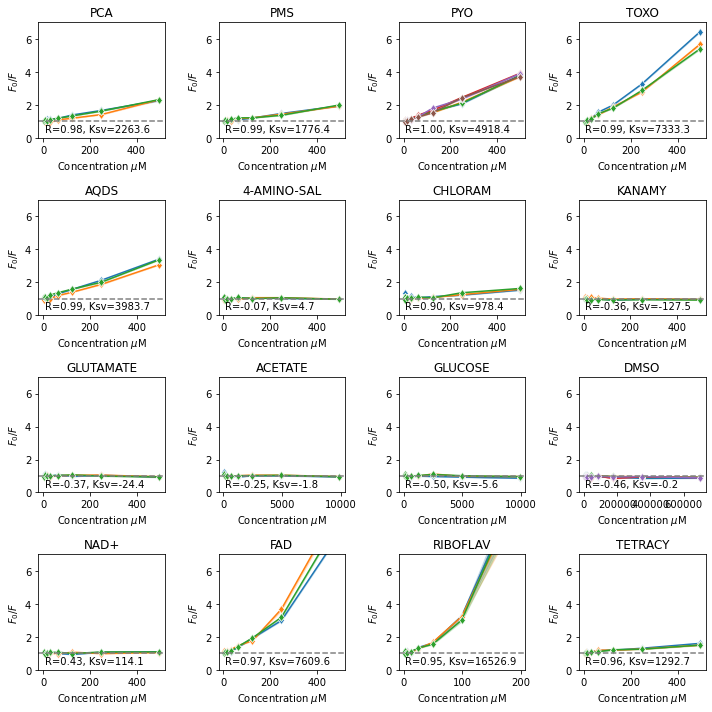

In [9]:
fig, axs = plt.subplots(figsize=(10,10), ncols=4, nrows=4)
flat_axs = axs.flatten()
name_order = ['PCA', 'PMS', 'PYO', 'TOXO', 'AQDS', '4-AMINO-SAL', 'CHLORAM', 
              'KANAMY', 'GLUTAMATE', 'ACETATE', 'GLUCOSE', 'DMSO',
              'NAD+', 'FAD', 'RIBOFLAV', 'TETRACY']

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    sns.lineplot(data=qdf_post, x='concentration', y='F0_F_ratio', 
                 color='m', marker='d', markersize=6,
                 hue=qdf_post[['date', 'replicate']].apply(tuple, axis=1),
                 legend=False)
    
    corr = qdf_post.corr().loc['concentration', 'F0_F_ratio']
    slope = rtdp_fits.loc[qname]['K_SV (/M)']
    plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.1f}'.format(corr, slope),
             transform=my_ax.transAxes)
    plt.axhline(1, ls='--', color='grey')
    
    plt.title(qname)
    plt.ylim(0, 7)
    plt.xlabel('Concentration $\mu$M')
    plt.ylabel('$F_0 / F$')
    
plt.tight_layout()
plt.savefig('../figures/rtdp_vitro_SV_plots.png', facecolor='w', dpi=600)
plt.show()